In [ ]:
!pip install pandas
!pip install numpy
!pip install requests
!pip install lxml
!pip install yfinance
!pip install sklearn
!pip install matplotlib
!pip install pandas_datareader

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
import lxml
import requests

# Technical Indicators
import talib as ta

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Data fetching
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [2]:
#data frame for the original model.
df = yf.download('AOT.bk', start='2023-06-01', end='2023-12-10', interval = '1h')
df = df.dropna()
df = df.iloc[:,:4]

#data frame for my model, I want to keep the volume and adj price.
df2 = yf.download('AOT.bk', start='2023-06-01', end='2023-12-10', interval = '1h')
df = df.dropna()
df2 = df2.iloc[:,:6]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# making indicator columns (X) for the original model;
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X = df.iloc[:,:9]

# indicators columns (X) for my model;
sett = yf.download('^SET.bk', start='2023-06-01', end='2023-12-10', interval = '1h')
df2['set_index'] = sett['Close']
df2['S_5'] = df2['Close'].rolling(window=5).mean()
df2['S_10'] = df2['Close'].rolling(window=10).mean()
df2['Corr'] = df2['Close'].rolling(window=10).corr(df2['S_10'])
df2['RSI'] = ta.RSI(np.array(df2['Close']), timeperiod =10)
df2['Open-Close'] = df2['Open'] - df2['Close'].shift(1)
df2['Open-Open'] = df2['Open'] - df2['Open'].shift(1)
macd, signal, _ = ta.MACD(df2['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df2['MACD'] = macd
df2['MACD_Signal'] = signal
df2['SAR'] = ta.SAR(df2['High'], df2['Low'], acceleration = 0.02, maximum = 0.2)
df2['Signal'] = np.nan
df2.loc[(df2['Close'] < df2['SAR']), 'Signal'] = -1
df2.loc[(df2['Close'] > df2['SAR']), 'Signal'] = 1
df2 = df2.dropna()
X2 = df2.iloc[:,:]

[*********************100%%**********************]  1 of 1 completed


In [4]:
# making target column (y) for the original model and my model

y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)
y2 = np.where(df2['Close'].shift(-1) > df2['Close'],1,-1)

In [5]:
#split for testing

split = int(0.8*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

split2 = int(0.8*len(df2))
X2_train, X2_test, y2_train, y2_test = X2[:split], X2[split:], y2[:split], y2[split:]

In [6]:
#model training
model = LogisticRegression(max_iter = 1000000000)
model = model.fit (X_train,y_train)

model2 = LogisticRegression(max_iter = 1000000000)
model2 = model2.fit (X2_train,y2_train)

In [7]:
#shows the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))
pd.DataFrame(zip(X2.columns, np.transpose(model2.coef_)))

,0,1
0,Open,[-3.150288600664614e-05]
1,High,[-3.161905787224996e-05]
2,Low,[-3.144764621568353e-05]
3,Close,[-3.16004376514877e-05]
4,Adj Close,[-3.16004376514877e-05]
5,Volume,[3.189643868148945e-08]
6,set_index,[-0.0006715226810765231]
7,S_5,[-3.152510535971017e-05]
8,S_10,[-3.152327294802673e-05]
9,Corr,[-1.0618431773445799e-07]


In [8]:
probability = model.predict_proba(X_test)
probability2 = model2.predict_proba(X2_test)
print (probability)

[[0.65738257 0.34261743]
 [0.68492082 0.31507918]
 [0.73975281 0.26024719]
 [0.70900922 0.29099078]
 [0.72278554 0.27721446]
 [0.5692858  0.4307142 ]
 [0.59173504 0.40826496]
 [0.61542857 0.38457143]
 [0.70802214 0.29197786]
 [0.80239519 0.19760481]
 [0.6986752  0.3013248 ]
 [0.77679393 0.22320607]
 [0.70902437 0.29097563]
 [0.60703533 0.39296467]
 [0.76929493 0.23070507]
 [0.70303282 0.29696718]
 [0.80930019 0.19069981]
 [0.59760477 0.40239523]
 [0.5521648  0.4478352 ]
 [0.54771266 0.45228734]
 [0.60799943 0.39200057]
 [0.79120979 0.20879021]
 [0.62324139 0.37675861]
 [0.59460404 0.40539596]
 [0.84365526 0.15634474]
 [0.79754357 0.20245643]
 [0.67287339 0.32712661]
 [0.75764898 0.24235102]
 [0.79313653 0.20686347]
 [0.90140955 0.09859045]
 [0.73852647 0.26147353]
 [0.73913254 0.26086746]
 [0.57553345 0.42446655]
 [0.8576444  0.1423556 ]
 [0.65303241 0.34696759]
 [0.64727263 0.35272737]
 [0.62973353 0.37026647]
 [0.83178865 0.16821135]
 [0.83904322 0.16095678]
 [0.63956183 0.36043817]


In [9]:
predicted = model.predict(X_test)
predicted2 = model2.predict(X2_test)

In [10]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.confusion_matrix(y2_test, predicted2))

[[93 11]
 [34 14]]
[[92  1]
 [43  1]]


In [11]:
print(metrics.classification_report(y_test, predicted))
print(metrics.classification_report(y2_test, predicted2))

              precision    recall  f1-score   support

          -1       0.73      0.89      0.81       104
           1       0.56      0.29      0.38        48

    accuracy                           0.70       152
   macro avg       0.65      0.59      0.59       152
weighted avg       0.68      0.70      0.67       152

              precision    recall  f1-score   support

          -1       0.68      0.99      0.81        93
           1       0.50      0.02      0.04        44

    accuracy                           0.68       137
   macro avg       0.59      0.51      0.43       137
weighted avg       0.62      0.68      0.56       137



In [12]:
print(model.score(X_test,y_test))
print(model2.score(X2_test,y2_test))

0.7039473684210527
0.6788321167883211


In [13]:
cross_val = cross_val_score(LogisticRegression(max_iter = 1000000000), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

cross_val2 = cross_val_score(LogisticRegression(max_iter = 1000000000), X2, y2, scoring='accuracy', cv=10)
print(cross_val2)
print(cross_val2.mean())

[0.72368421 0.72368421 0.71052632 0.71052632 0.71052632 0.72368421
 0.71052632 0.68421053 0.71052632 0.63157895]
0.7039473684210527
[0.70666667 0.72       0.72       0.72       0.72       0.71621622
 0.71621622 0.71621622 0.71621622 0.67567568]
0.7127207207207207


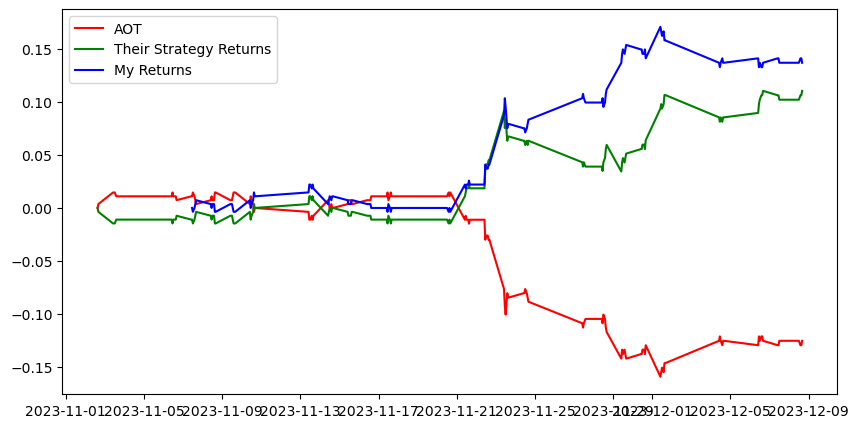

In [14]:
#the original method's graph
df['Predicted_Signal'] = model.predict(X)
df['AOT_movement'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_AOT_returns = np.cumsum(df[split:]['AOT_movement'])
df['Original_Startegy_returns'] = df['AOT_movement']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Original_Startegy_returns'])

#my model's graph
df2.loc[:, 'Predicted_Signal2'] = model2.predict(X2)
df2.loc[:, 'AOT_movement'] = np.log(df2['Close'] / df2['Close'].shift(1))
df2.loc[:, 'My_returns'] = df2['AOT_movement'] * df2['Predicted_Signal2'].shift(1)
Cumulative_My_returns = np.cumsum(df2[split:]['My_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_AOT_returns, color='r',label = 'AOT')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Their Strategy Returns')
plt.plot(Cumulative_My_returns, color='b', label = 'My Returns')
plt.legend()
plt.show()